# Path

In [1]:
covid_19_data_path='E:\Big data\covid19 Analysis\Covid-19-Analysis'

# Imports

In [2]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import plotly.graph_objects as plt_go

C:\Users\ROMIL\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# COVID-19 Analysis

In [3]:
covid_19_confirmed_cases=pd.read_csv(covid_19_data_path+'/covid_confirmed_usafacts.csv')
usa_county_population=pd.read_csv(covid_19_data_path+'/covid_county_population_usafacts.csv')
covid_19_deaths=pd.read_csv(covid_19_data_path+'/covid_deaths_usafacts.csv')

In [4]:
covid_19_confirmed_cases.head()

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,40,42,42,42,45,48,53,53,58,61
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,171,173,174,175,181,187,188,189,196,205
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,37,37,39,42,43,45,45,47,47,51
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,42,42,42,42,42,42,42,43,43,44


In [5]:
# fetching all the dates columns
dates=covid_19_confirmed_cases.columns[4:]
dates

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '4/28/20', '4/29/20', '4/30/20', '5/1/20', '5/2/20', '5/3/20', '5/4/20',
       '5/5/20', '5/6/20', '5/7/20'],
      dtype='object', length=107)

# Helper functions

#### Function to count number of confirmed cases or number of death cases per day. It takes arguments a dataframe and dates

In [6]:
def cases_per_day_count(df,dates):
    dict_cases_per_day={}
    day_count=1
    for date in dates:
        dict_cases_per_day[day_count]=df[date].sum()
        day_count+=1
    cases_per_day = pd.DataFrame(list(dict_cases_per_day.items()),columns = ['Day','NumberOfCases'])
    return cases_per_day

#### Function to count number of new confirmed cases. It takes arguments a dataframe.

In [7]:
def new_cases_per_day_count(df_cases_per_day):
    dict_new_cases_per_day={}
    # for the first day
    dict_new_cases_per_day[1]=df_cases_per_day['NumberOfCases'][0]
    curr_day=2
    while curr_day<=len(df_cases_per_day):
        dict_new_cases_per_day[curr_day]=df_cases_per_day['NumberOfCases'][curr_day-1]-df_cases_per_day['NumberOfCases'][curr_day-2]
        curr_day+=1
    new_cases_per_day = pd.DataFrame(list(dict_new_cases_per_day.items()),columns = ['Day','NumberOfNewCases'])
    return new_cases_per_day

#### Function to count number of confirmed cases or number of death cases per week. It takes arguments a dataframe and dates

In [8]:
# Here, we are not considering the last week because it has only 2 days' data available. So, it might give us false impression
def cases_per_week_count(df_cases_per_day,dates):
    dict_cases_per_week={}
    week=0
    curr_day=7
    while curr_day<len(dates):
        week+=1
        dict_cases_per_week[week]=df_cases_per_day['NumberOfCases'][curr_day-1]
        curr_day+=7
    cases_per_week = pd.DataFrame(list(dict_cases_per_week.items()),columns = ['Week','NumberOfCases'])
    return cases_per_week

#### Function to count number of new confirmed cases or number of new deaths cases per week. It takes an argument a dataframe.

In [9]:
def new_cases_per_week_count(df_cases_per_week):
    dict_new_cases_per_week={}
    # for the first week
    dict_new_cases_per_week[1]=df_cases_per_week['NumberOfCases'][0]
    curr_week=2
    while curr_week<=len(df_cases_per_week):
        dict_new_cases_per_week[curr_week]=df_cases_per_week['NumberOfCases'][curr_week-1]-df_cases_per_week['NumberOfCases'][curr_week-2]
        curr_week+=1
    new_cases_per_week = pd.DataFrame(list(dict_new_cases_per_week.items()),columns = ['Week','NumberOfNewCases'])
    return new_cases_per_week

## 1. Total confirmed cases per day in the country.

In [10]:
confirmed_cases_per_day=cases_per_day_count(covid_19_confirmed_cases,dates)
confirmed_cases_per_day

,Day,NumberOfCases
0,1,1
1,2,1
2,3,2
3,4,2
4,5,5
...,...,...
102,103,1151528
103,104,1173190
104,105,1197432
105,106,1221118


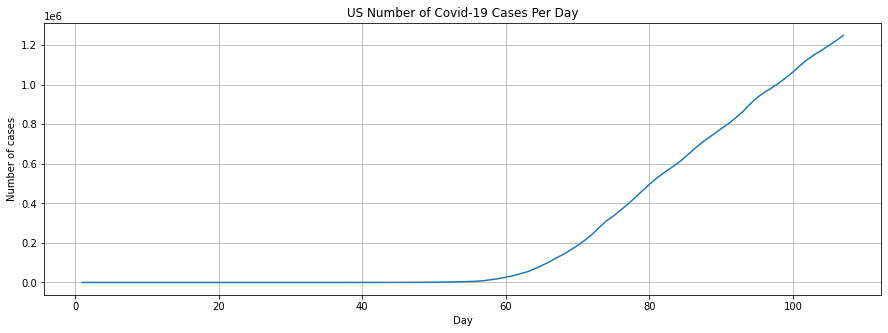

In [11]:
plt.figure(figsize=(15,5))
plt.title('US Number of Covid-19 Cases Per Day')
plt.xlabel('Day')
plt.ylabel('Number of cases')
plt.plot(confirmed_cases_per_day['Day'],confirmed_cases_per_day['NumberOfCases'])
plt.grid()
plt.show()

## 2. Total confirmed new cases per day in the country.

In [12]:
new_confirmed_cases_per_day=new_cases_per_day_count(confirmed_cases_per_day)
new_confirmed_cases_per_day

,Day,NumberOfNewCases
0,1,1
1,2,0
2,3,1
3,4,0
4,5,3
...,...,...
102,103,25176
103,104,21662
104,105,24242
105,106,23686


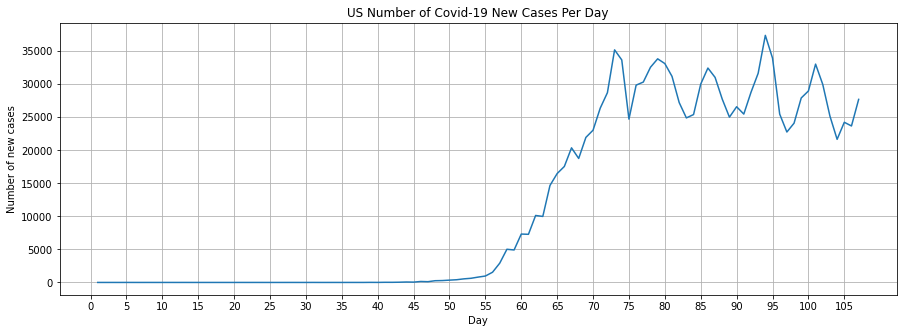

In [53]:
plt.figure(figsize=(15,5))
plt.title('US Number of Covid-19 New Cases Per Day')
plt.xlabel('Day')
plt.ylabel('Number of new cases')
plt.plot(new_confirmed_cases_per_day['Day'],new_confirmed_cases_per_day['NumberOfNewCases'])
plt.grid()
plt.xticks(range(0,110,5))
plt.show()

## 3. Total confirmed cases per week in the country.

In [54]:
confirmed_cases_per_week=cases_per_week_count(confirmed_cases_per_day,dates)
confirmed_cases_per_week

,Week,NumberOfCases
0,1,6
1,2,11
2,3,12
3,4,14
4,5,18
5,6,81
6,7,1039
7,8,6302
8,9,53896
9,10,186755


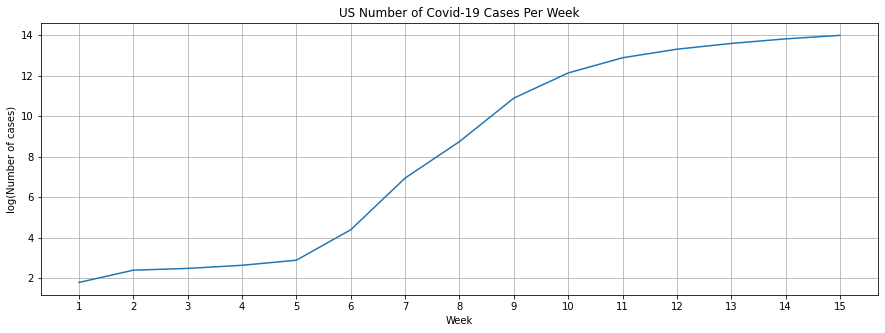

In [57]:
plt.figure(figsize=(15,5))
plt.title('US Number of Covid-19 Cases Per Week')
plt.xlabel('Week')
plt.ylabel('log(Number of cases)')
plt.xticks(range(1,16))
plt.plot(confirmed_cases_per_week['Week'],np.log(confirmed_cases_per_week['NumberOfCases']))
plt.grid()
plt.show()

## 4. Number of new confirmed cases per week in the the country

In [16]:
new_confirmed_cases_per_week=new_cases_per_week_count(confirmed_cases_per_week)
new_confirmed_cases_per_week

,Week,NumberOfNewCases
0,1,6
1,2,5
2,3,1
3,4,2
4,5,4
5,6,63
6,7,958
7,8,5263
8,9,47594
9,10,132859


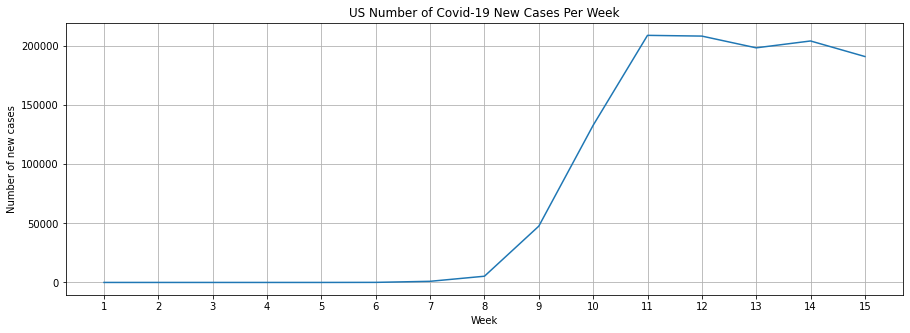

In [58]:
plt.figure(figsize=(15,5))
plt.title('US Number of Covid-19 New Cases Per Week')
plt.xlabel('Week')
plt.ylabel('Number of new cases')
plt.xticks(range(1,16))
plt.plot(new_confirmed_cases_per_week['Week'],(new_confirmed_cases_per_week['NumberOfNewCases']))
plt.grid()
plt.show()

As we can see in the plot 

## 5. Total deaths per day in the country.

In [18]:
deaths_per_day=cases_per_day_count(covid_19_deaths,dates)
deaths_per_day

,Day,NumberOfCases
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
102,103,66966
103,104,67924
104,105,70364
105,106,73010


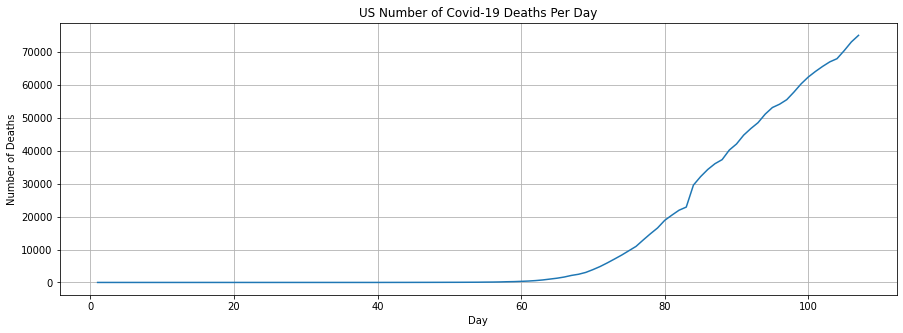

In [19]:
plt.figure(figsize=(15,5))
plt.title('US Number of Covid-19 Deaths Per Day')
plt.xlabel('Day')
plt.ylabel('Number of Deaths')
plt.plot(deaths_per_day['Day'],deaths_per_day['NumberOfCases'])
plt.grid()
plt.show()

## 6. Total new deaths per day in the country.

In [20]:
new_deaths_per_day=new_cases_per_day_count(deaths_per_day)
new_deaths_per_day

,Day,NumberOfNewCases
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
102,103,1379
103,104,958
104,105,2440
105,106,2646


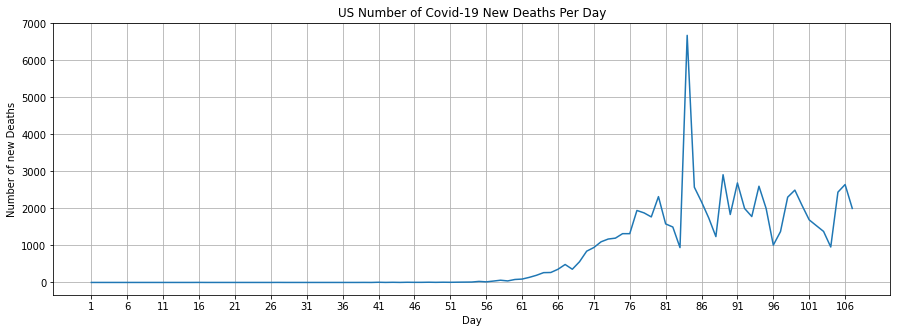

In [59]:
plt.figure(figsize=(15,5))
plt.title('US Number of Covid-19 New Deaths Per Day')
plt.xlabel('Day')
plt.ylabel('Number of new Deaths')
plt.plot(new_deaths_per_day['Day'],new_deaths_per_day['NumberOfNewCases'])
plt.xticks(range(1,110,5))
plt.grid()
plt.show()

## 7. Total deaths per week in the country.

In [22]:
deaths_per_week=cases_per_week_count(deaths_per_day,dates)
deaths_per_week

,Week,NumberOfCases
0,1,0
1,2,0
2,3,1
3,4,2
4,5,2
5,6,9
6,7,34
7,8,115
8,9,754
9,10,3890


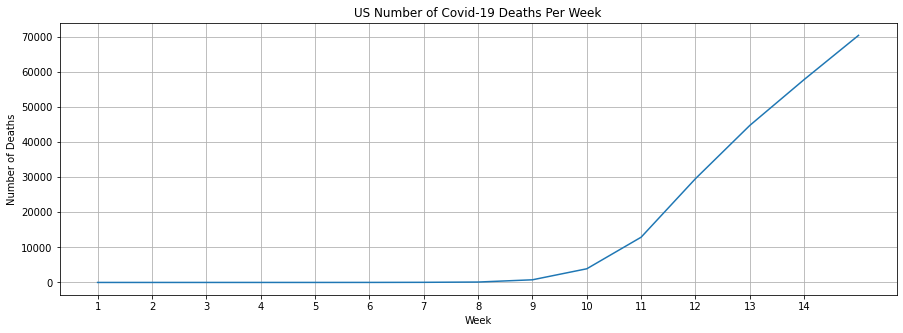

In [23]:
plt.figure(figsize=(15,5))
plt.title('US Number of Covid-19 Deaths Per Week')
plt.xlabel('Week')
plt.ylabel('Number of Deaths')
plt.xticks(range(1,15))
plt.plot(deaths_per_week['Week'],(deaths_per_week['NumberOfCases']))
plt.grid()
plt.show()

## 8. Number of New Deaths per week in the the country

In [24]:
new_deaths_per_week=new_cases_per_week_count(deaths_per_week)
new_deaths_per_week

,Week,NumberOfNewCases
0,1,0
1,2,0
2,3,1
3,4,1
4,5,0
5,6,7
6,7,25
7,8,81
8,9,639
9,10,3136


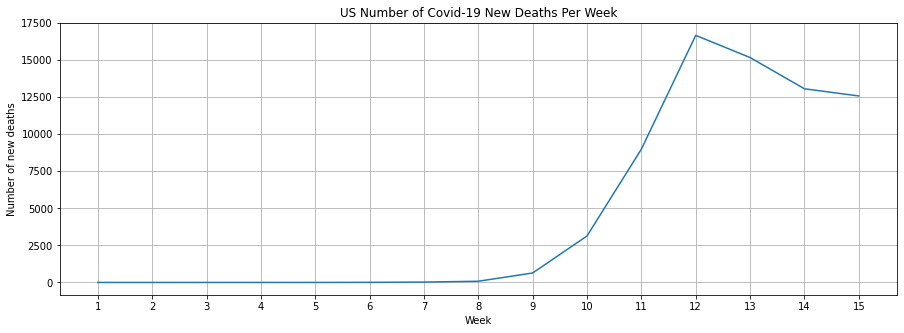

In [60]:
plt.figure(figsize=(15,5))
plt.title('US Number of Covid-19 New Deaths Per Week')
plt.xlabel('Week')
plt.ylabel('Number of new deaths')
plt.xticks(range(1,16))
plt.plot(new_deaths_per_week['Week'],(new_deaths_per_week['NumberOfNewCases']))
plt.grid()
plt.show()

## 9.Covid 19 cases in each state

In [61]:
per_state_cases=covid_19_confirmed_cases.groupby('State').agg('sum').sort_values('5/7/20', ascending=False).reset_index()
per_state_cases=per_state_cases[['State','5/7/20']]
per_state_cases.columns=['State','Total_Cases']
per_state_cases

,State,Total_Cases
0,NY,327538
1,NJ,133635
2,MA,73721
3,IL,70871
4,CA,62302
5,PA,52915
6,MI,45646
7,FL,38828
8,TX,35390
9,CT,31784


In [62]:
fig = plt_go.Figure(data=plt_go.Choropleth(
    locations=per_state_cases['State'],
    z = per_state_cases['Total_Cases'].astype(float),  # Data to be color-coded
    locationmode = 'USA-states',     # set of locations match entries in `locations`
    colorscale = 'YlOrRd',
    colorbar_title = "Count",
))

fig.update_layout(
    title_text = 'US Covid19 cases by State',
    geo_scope='usa',
)

fig.show()

We can see that NY has highest number of cases, followed by NJ and MA. Most notable fact is that MA being a small state, has more number of covid-19 cases than CA.

## 10. Covid-19 cases per 100000 people in each state 

In [63]:
sorted_per_state_cases=per_state_cases.sort_values(by='State').reset_index(drop=True)
sorted_per_state_cases

,State,Total_Cases
0,AK,375
1,AL,9046
2,AR,3694
3,AZ,9945
4,CA,62302
5,CO,18371
6,CT,31784
7,DC,5654
8,DE,5939
9,FL,38828


In [64]:
per_state_population=usa_county_population.groupby('State').agg('sum').sort_values(by='State').reset_index()
per_state_population=per_state_population[['State','population']]
per_state_population

,State,population
0,AK,731545
1,AL,4903185
2,AR,3017804
3,AZ,7278717
4,CA,39512223
5,CO,5758736
6,CT,3565287
7,DC,705749
8,DE,973764
9,FL,21477737


In [66]:
combined_state_population=sorted_per_state_cases
combined_state_population['Population']=per_state_population['population']
combined_state_population

,State,Total_Cases,Population
0,AK,375,731545
1,AL,9046,4903185
2,AR,3694,3017804
3,AZ,9945,7278717
4,CA,62302,39512223
5,CO,18371,5758736
6,CT,31784,3565287
7,DC,5654,705749
8,DE,5939,973764
9,FL,38828,21477737


In [67]:
combined_state_population['cases_per_100000_people']=(combined_state_population['Total_Cases']/combined_state_population['Population'])*100000
combined_state_population=combined_state_population.sort_values(by='cases_per_100000_people',ascending=False).reset_index(drop=True)
combined_state_population

,State,Total_Cases,Population,cases_per_100000_people
0,NY,327538,19453561,1683.691742
1,NJ,133635,8882190,1504.527600
2,MA,73721,6892503,1069.582414
3,RI,10530,1059361,993.995437
4,CT,31784,3565287,891.485033
5,DC,5654,705749,801.134681
6,LA,30652,4648794,659.353802
7,DE,5939,973764,609.901372
8,IL,70871,12671821,559.280312
9,MD,29374,6045680,485.867595


We can clearly see that NY and NJ have highest number of cases per population. But surprisingly CA which was no 4 in terms of cases, is now no 33 in cases per population. While some smaller state showing more cases per population.

## 11. Top 10 counties with the most known number of covid-19 cases.

In [68]:
sorted_covid_19_confirmed_cases=covid_19_confirmed_cases.sort_values(by='5/7/20',ascending=False)
counties_with_most_known_cases=sorted_covid_19_confirmed_cases.head(10)
counties_with_most_known_cases=counties_with_most_known_cases.reset_index(drop=True)
counties_with_most_known_cases

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20
0,36081,Queens County,NY,36,0,0,0,0,0,0,...,49929,50741,51631,52274,53039,53640,54090,54448,54880,55450
1,36047,Kings County,NY,36,0,0,0,0,0,0,...,43587,44236,44872,45519,46275,46839,47183,47579,47974,48550
2,17031,Cook County,IL,17,0,0,1,1,1,1,...,33449,34880,36513,38668,40227,42324,43715,45223,46689,48341
3,36005,Bronx County,NY,36,0,0,0,0,0,0,...,35994,36600,37244,37785,38450,38916,39223,39476,39839,40181
4,36059,Nassau County,NY,36,0,0,0,0,0,0,...,35085,35505,35854,36161,36519,36780,36965,37152,37350,37593
5,36103,Suffolk County,NY,36,0,0,0,0,0,0,...,32724,33265,33664,34037,34478,34855,35077,35275,35543,35892
6,36119,Westchester County,NY,36,0,0,0,0,0,0,...,28245,28626,28970,29232,29626,29884,30097,30240,30426,30708
7,6037,Los Angeles County,CA,6,0,0,0,0,1,1,...,20976,22485,23182,24215,24894,25662,26217,27815,28644,29427
8,36061,New York County,NY,36,0,0,0,0,0,0,...,21312,21604,21920,22175,22496,22741,22900,23054,23257,23529
9,26163,Wayne County,MI,26,0,0,0,0,0,0,...,16173,16494,16729,16970,17106,17298,17314,17391,17571,17667


### Per week number of cases distribution

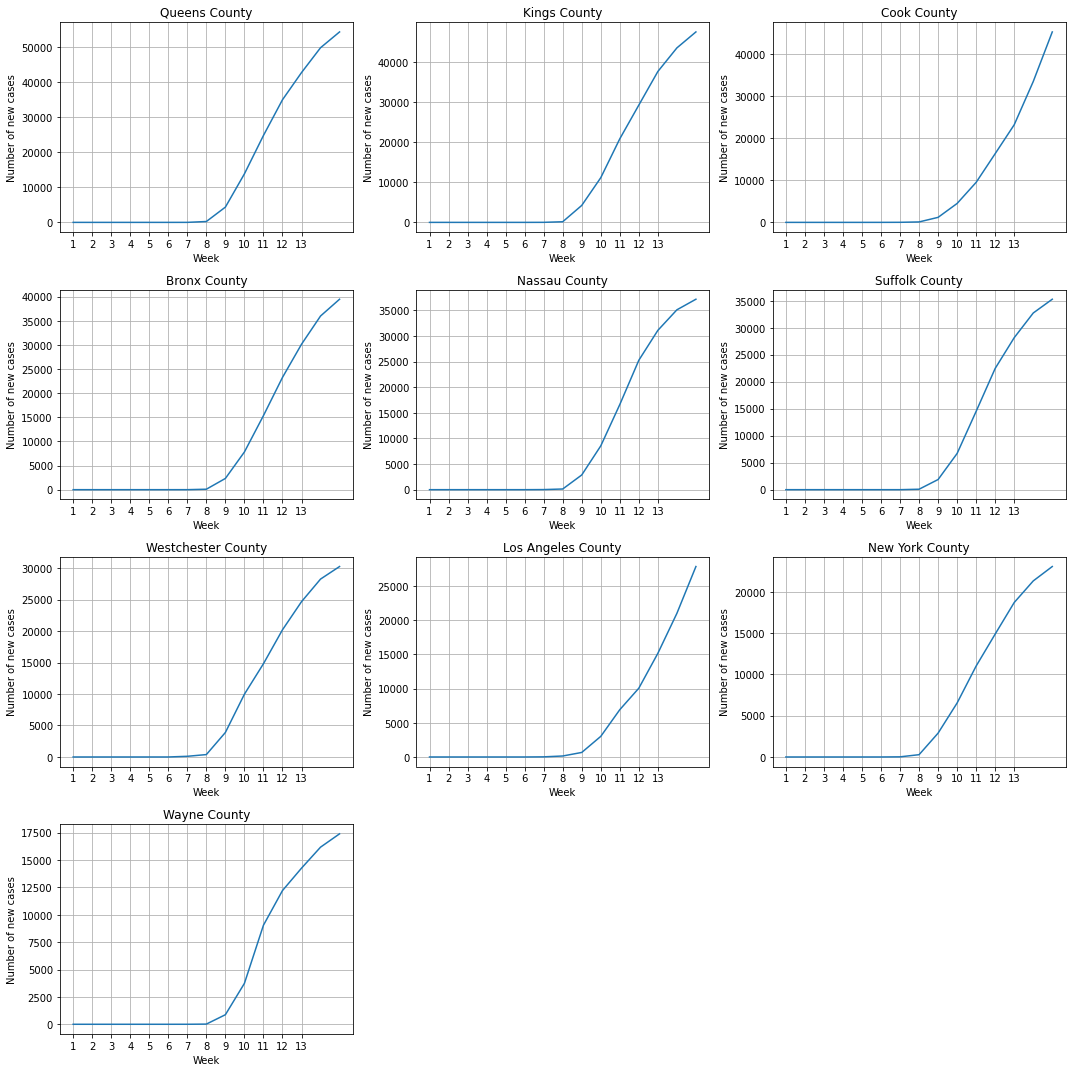

In [69]:
fig=plt.figure(figsize=(15,15))
for county_with_most_known_cases in range(len(counties_with_most_known_cases)):
    out=cases_per_week_count(cases_per_day_count(counties_with_most_known_cases.iloc[county_with_most_known_cases],dates),dates)
    ax = fig.add_subplot(4,3,county_with_most_known_cases+1)
    ax.plot(out['Week'],out['NumberOfCases'])
    ax.set_title(counties_with_most_known_cases['County Name'][county_with_most_known_cases])
    ax.set_xlabel('Week')
    ax.set_ylabel('Number of new cases')
    ax.grid()
    ax.set_xticks(range(1,14))
fig.tight_layout()
plt.show()

As we can clearly see that all the counties have similarity in terms of the growth in number of cases each week. It can be observed that almost all of them showed similar exponential increase in cases after 8th week. The difference between all the counties are number of cases increasing every week.

### Per week number of new cases distribution

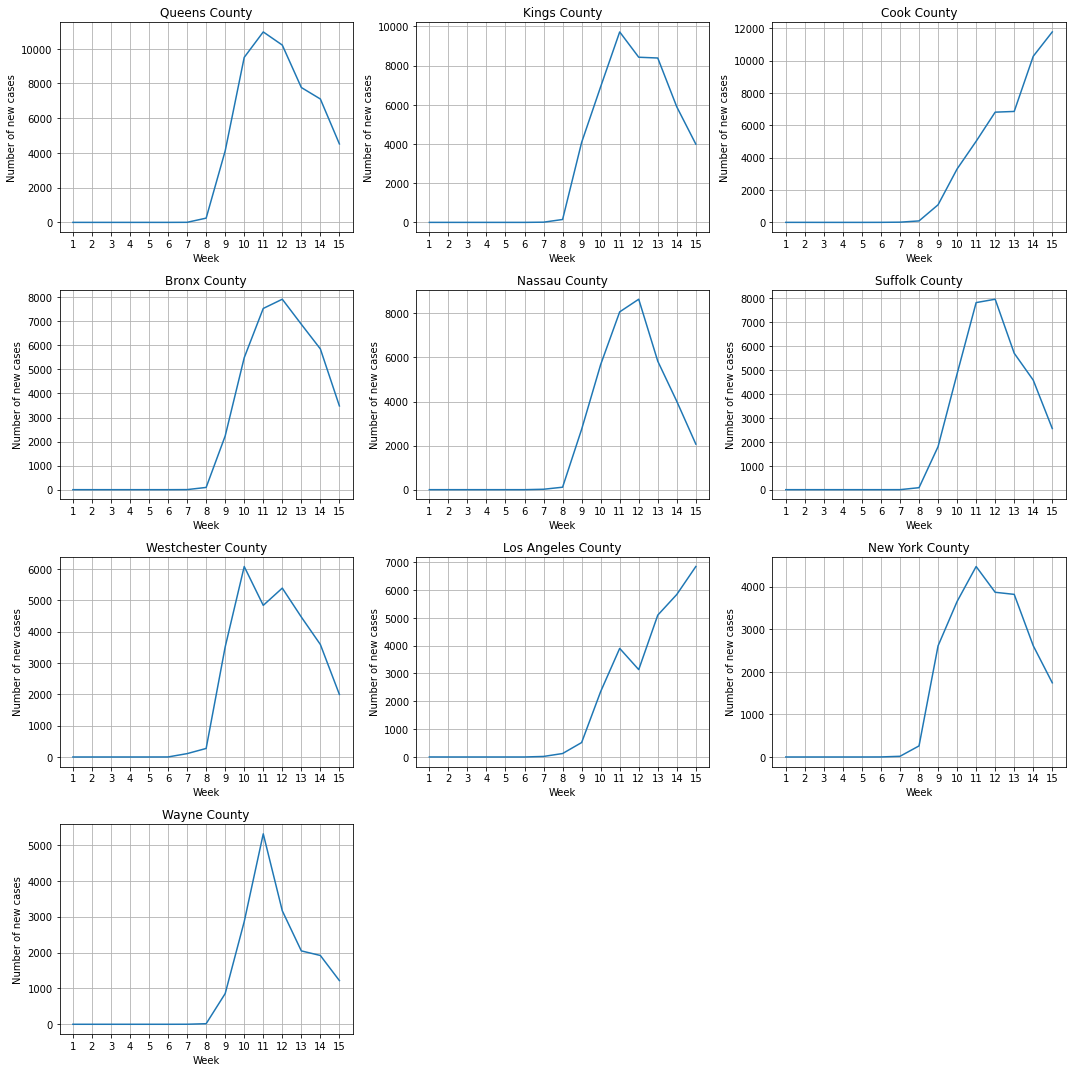

In [70]:
fig=plt.figure(figsize=(15,15))
for county_with_most_known_cases in range(len(counties_with_most_known_cases)):
    out=new_cases_per_week_count(cases_per_week_count(cases_per_day_count(counties_with_most_known_cases.iloc[county_with_most_known_cases],dates),dates))
    ax = fig.add_subplot(4,3,county_with_most_known_cases+1)
    ax.plot(out['Week'],out['NumberOfNewCases'])
    ax.set_title(counties_with_most_known_cases['County Name'][county_with_most_known_cases])
    ax.set_xlabel('Week')
    ax.set_ylabel('Number of new cases')
    ax.grid()
    ax.set_xticks(range(1,16))
fig.tight_layout()
plt.show()

## 12. Compute the number of known cases per population in each county.

In [71]:
combined_df_population_confirmed_cases=usa_county_population[['County Name','population','State']]
combined_df_population_confirmed_cases['confirmed_cases']=covid_19_confirmed_cases['5/7/20']
combined_df_population_confirmed_cases

,County Name,population,State,confirmed_cases
0,Statewide Unallocated,0,AL,0
1,Autauga County,55869,AL,61
2,Baldwin County,223234,AL,205
3,Barbour County,24686,AL,51
4,Bibb County,22394,AL,44
...,...,...,...,...
3190,Sweetwater County,42343,WY,12
3191,Teton County,23464,WY,67
3192,Uinta County,20226,WY,6
3193,Washakie County,7805,WY,5


In [72]:
combined_df_population_confirmed_cases_filtered=combined_df_population_confirmed_cases[(combined_df_population_confirmed_cases['population']!=0) & (combined_df_population_confirmed_cases['confirmed_cases']!=0)]
combined_df_population_confirmed_cases_filtered.head()

,County Name,population,State,confirmed_cases
1,Autauga County,55869,AL,61
2,Baldwin County,223234,AL,205
3,Barbour County,24686,AL,51
4,Bibb County,22394,AL,44
5,Blount County,57826,AL,44


In [73]:
combined_df_population_confirmed_cases_filtered['cases_per_100000_people']=combined_df_population_confirmed_cases_filtered['confirmed_cases']/combined_df_population_confirmed_cases_filtered['population']*100000
combined_df_population_confirmed_cases_filtered=combined_df_population_confirmed_cases_filtered.sort_values(by='cases_per_100000_people',ascending=False).reset_index(drop=True)
combined_df_population_confirmed_cases_filtered.head()

,County Name,population,State,confirmed_cases,cases_per_100000_people
0,Trousdale County,11284,TN,1356,12017.015243
1,Lincoln County,13024,AR,899,6902.641278
2,Nobles County,21629,MN,1153,5330.805862
3,Dakota County,20026,NE,1017,5078.398082
4,Bledsoe County,15064,TN,602,3996.282528


## 13. Counties with highest number of known cases per population.

In [74]:
counties_with_highest_cases_per_population_ratio=combined_df_population_confirmed_cases_filtered.head(10)
counties_with_highest_cases_per_population_ratio

,County Name,population,State,confirmed_cases,cases_per_100000_people
0,Trousdale County,11284,TN,1356,12017.015243
1,Lincoln County,13024,AR,899,6902.641278
2,Nobles County,21629,MN,1153,5330.805862
3,Dakota County,20026,NE,1017,5078.398082
4,Bledsoe County,15064,TN,602,3996.282528
5,Cass County,37689,IN,1469,3897.688981
6,Rockland County,325789,NY,12280,3769.310812
7,Marion County,65093,OH,2350,3610.219225
8,Westchester County,967506,NY,30708,3173.933805
9,Colfax County,10709,NE,338,3156.223737


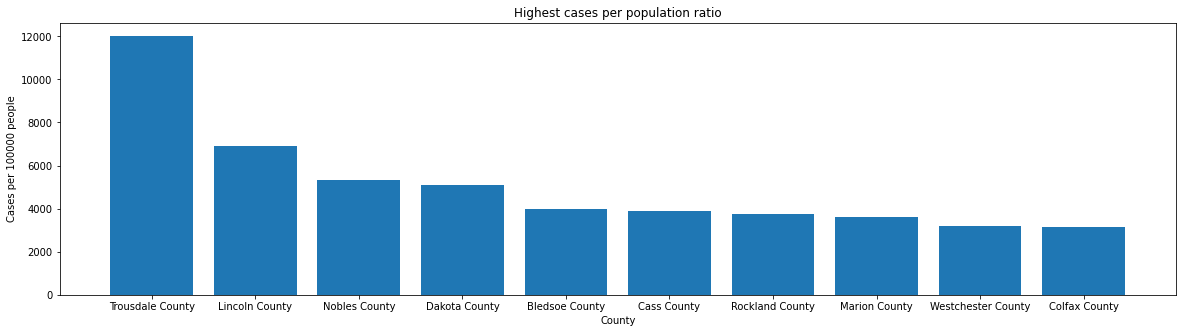

In [75]:
plt.figure(figsize=(20,5))
plt.bar(counties_with_highest_cases_per_population_ratio['County Name'],counties_with_highest_cases_per_population_ratio['cases_per_100000_people'])
plt.title('Highest cases per population ratio')
plt.xlabel('County')
plt.ylabel('Cases per 100000 people')
plt.show()

## 14. Counties with lowest number of known cases per population(Considering counties with atleast a known case).

In [76]:
counties_with_lowest_cases_per_population_ratio=combined_df_population_confirmed_cases_filtered.tail(10).sort_values(by='cases_per_100000_people')
counties_with_lowest_cases_per_population_ratio

,County Name,population,State,confirmed_cases,cases_per_100000_people
2879,Tehama County,65084,CA,1,1.536476
2878,Warren County,39191,PA,1,2.551606
2877,Wood County,72999,WI,2,2.739764
2876,Polk County,32149,MO,1,3.110517
2875,Park County,29194,WY,1,3.425361
2874,Lincoln County,27593,WI,1,3.624108
2873,Tuolumne County,54478,CA,2,3.671207
2872,Harlan County,26010,KY,1,3.844675
2871,Audrain County,25388,MO,1,3.938869
2870,Crook County,24404,OR,1,4.097689


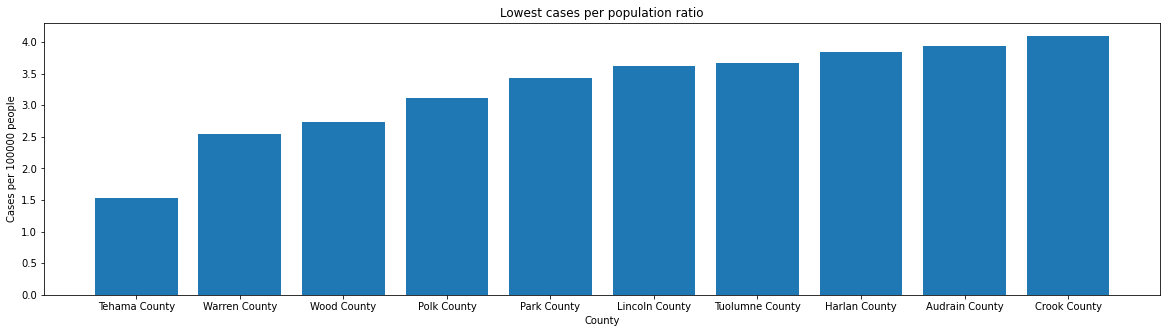

In [77]:
plt.figure(figsize=(20,5))
plt.bar(counties_with_lowest_cases_per_population_ratio['County Name'],counties_with_lowest_cases_per_population_ratio['cases_per_100000_people'])
plt.title('Lowest cases per population ratio')
plt.xlabel('County')
plt.ylabel('Cases per 100000 people')
plt.show()

## 15. Death rate (deaths/ known cases) in each county that have both deaths and known cases. The mean and standard deviation of the results. 

In [78]:
combined_df_death_and_confirmed_cases=covid_19_deaths[['County Name', 'State']]
combined_df_death_and_confirmed_cases['deaths']=covid_19_deaths['5/7/20']
combined_df_death_and_confirmed_cases['confirmed_cases']=covid_19_confirmed_cases['5/7/20']

In [79]:
combined_df_death_and_confirmed_cases_filtered=combined_df_death_and_confirmed_cases[(combined_df_death_and_confirmed_cases['deaths']>0) & (combined_df_death_and_confirmed_cases['confirmed_cases']>0)].reset_index(drop=True)
combined_df_death_and_confirmed_cases_filtered.head()

,County Name,State,deaths,confirmed_cases
0,Autauga County,AL,3,61
1,Baldwin County,AL,5,205
2,Barbour County,AL,1,51
3,Bullock County,AL,1,18
4,Butler County,AL,2,155


In [80]:
combined_df_death_and_confirmed_cases_filtered['death_rate']=combined_df_death_and_confirmed_cases_filtered['deaths']/combined_df_death_and_confirmed_cases_filtered['confirmed_cases']
combined_df_death_and_confirmed_cases_filtered.head()

,County Name,State,deaths,confirmed_cases,death_rate
0,Autauga County,AL,3,61,0.049180
1,Baldwin County,AL,5,205,0.024390
2,Barbour County,AL,1,51,0.019608
3,Bullock County,AL,1,18,0.055556
4,Butler County,AL,2,155,0.012903


Since the question says that counties that have both death and known cases,I have only considered data with confirmed cases > 0 and deaths > 0

In [81]:
print('Mean of Death Rate',combined_df_death_and_confirmed_cases_filtered['death_rate'].mean())
print('Standard Deviation of Death Rate',combined_df_death_and_confirmed_cases_filtered['death_rate'].std())

Mean of Death Rate 0.06988056419053439
Standard Deviation of Death Rate 0.08305334160414814


## 16. Checking if covid-19 have peaked in NYC (counties Bronx, Kings, New York, Queens and Richmond).

In [82]:
NYC_counties_data=covid_19_confirmed_cases[((covid_19_confirmed_cases['County Name']=='Queens County') | (covid_19_confirmed_cases['County Name']=='Kings County') | (covid_19_confirmed_cases['County Name']=='New York County') | (covid_19_confirmed_cases['County Name']=='Bronx County') | (covid_19_confirmed_cases['County Name']=='Richmond County')) & (covid_19_confirmed_cases['State']=='NY')]
NYC_counties_data=NYC_counties_data.reset_index(drop=True)
NYC_counties_data

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20
0,36005,Bronx County,NY,36,0,0,0,0,0,0,...,35994,36600,37244,37785,38450,38916,39223,39476,39839,40181
1,36047,Kings County,NY,36,0,0,0,0,0,0,...,43587,44236,44872,45519,46275,46839,47183,47579,47974,48550
2,36061,New York County,NY,36,0,0,0,0,0,0,...,21312,21604,21920,22175,22496,22741,22900,23054,23257,23529
3,36081,Queens County,NY,36,0,0,0,0,0,0,...,49929,50741,51631,52274,53039,53640,54090,54448,54880,55450
4,36085,Richmond County,NY,36,0,0,0,0,0,0,...,11516,11660,11811,11937,12094,12195,12255,12317,12401,12506


In [83]:
NYC_counties_cases_per_day=cases_per_day_count(NYC_counties_data,dates)
NYC_counties_new_cases_per_day=new_cases_per_day_count(NYC_counties_cases_per_day)
NYC_counties_new_cases_per_day

,Day,NumberOfNewCases
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
102,103,1977
103,104,1320
104,105,1223
105,106,1477


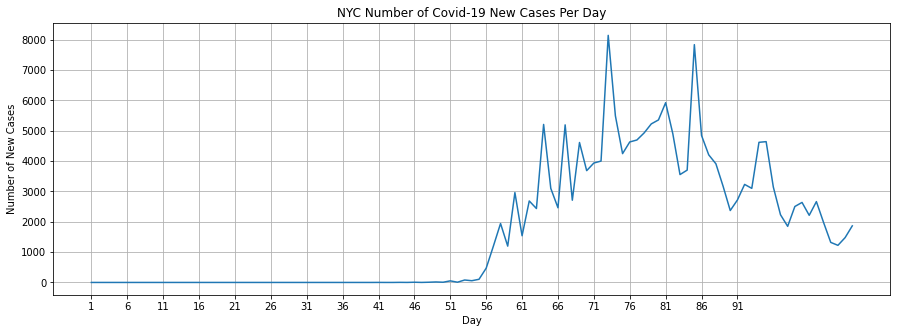

In [84]:
plt.figure(figsize=(15,5))
plt.plot(NYC_counties_new_cases_per_day['Day'],(NYC_counties_new_cases_per_day['NumberOfNewCases']))
plt.title('NYC Number of Covid-19 New Cases Per Day')
plt.xlabel('Day')
plt.ylabel('Number of New Cases')
plt.grid()
plt.xticks(range(1,95,5))
plt.show()

As we can see in the graph, we can analize that new confirmed cases goes up and down infrequently. We can see that during the last week, it reached the peek of more than 8000 cases in a single day but the day after that, it dropped below 4000. By looking at the graph we can see that it may have already peaked in the NYC with the current number below 2000.

## 17. Seattle (King county in Washington) also hopes that they have peaked.

In [85]:
Seattle=covid_19_confirmed_cases[(covid_19_confirmed_cases['County Name']=='King County') & (covid_19_confirmed_cases['State']=='WA')]
Seattle

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20
3019,53033,King County,WA,53,1,1,1,1,1,1,...,6001,6103,6207,6274,6351,6449,6545,6621,6704,6809


In [86]:
seattle_per_day_cases=cases_per_day_count(Seattle,dates)
seattle_new_cases_per_day=new_cases_per_day_count(seattle_per_day_cases)
seattle_new_cases_per_day

,Day,NumberOfNewCases
0,1,1
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
102,103,98
103,104,96
104,105,76
105,106,83


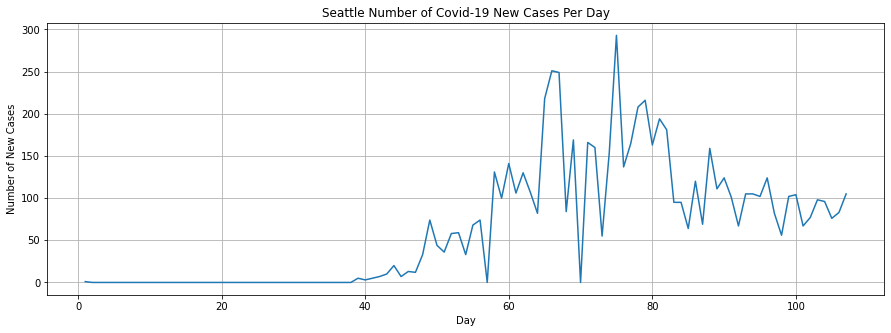

In [91]:
plt.figure(figsize=(15,5))
plt.plot(seattle_new_cases_per_day['Day'],seattle_new_cases_per_day['NumberOfNewCases'])
plt.title('Seattle Number of Covid-19 New Cases Per Day')
plt.xlabel('Day')
plt.ylabel('Number of New Cases')
plt.grid()
plt.show()

By looking at the graph, we can clearly say that the growth of new covid-19 cases has peaked.

## 17. Checking the growth of Covid-19 in San Deigo

In [88]:
San_Diego=covid_19_confirmed_cases[(covid_19_confirmed_cases['County Name']=='San Diego County') & (covid_19_confirmed_cases['State']=='CA')]
San_Diego

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20
229,6073,San Diego County,CA,6,0,0,0,0,0,0,...,3314,3432,3564,3711,3842,3927,4020,4160,4319,4429


In [89]:
San_Diego_per_day_cases=cases_per_day_count(San_Diego,dates)
San_Diego_new_cases_per_day=new_cases_per_day_count(San_Diego_per_day_cases)
San_Diego_new_cases_per_day

,Day,NumberOfNewCases
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
102,103,85
103,104,93
104,105,140
105,106,159


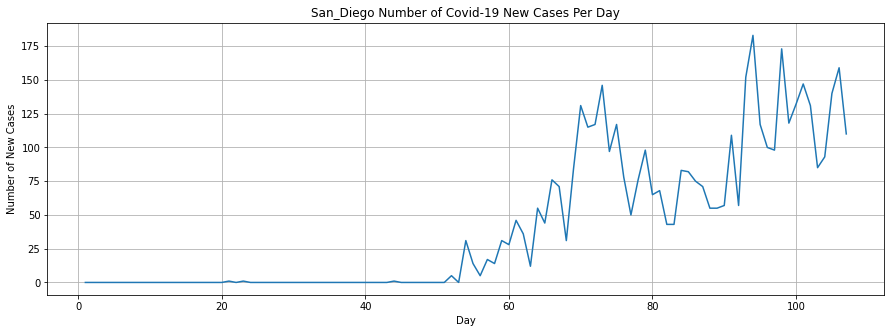

In [90]:
plt.figure(figsize=(15,5))
plt.plot(San_Diego_new_cases_per_day['Day'],San_Diego_new_cases_per_day['NumberOfNewCases'])
plt.title('San_Diego Number of Covid-19 New Cases Per Day')
plt.xlabel('Day')
plt.ylabel('Number of New Cases')
plt.grid()
plt.show()